<a href="https://colab.research.google.com/github/TashiNyangmi/MIT-Challenge-2020/blob/master/c006_final_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MIT COVID-19 Datathon**

#### **Team C-006**


# Environment Set-Up

## Packages

In [ ]:
# Import libraries
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
from sklearn.linear_model import LinearRegression

!pip install -U -q pandasql
import pandasql as psql
from pandasql import sqldf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# Import libraries for google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

# BigQuery Setup
project_id='mit-covid-19-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Authentication

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Functions

In [ ]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [ ]:
def get_data_from_gdrive(link):
  #extracting string following "=" in the link string
  fluff, id = link.split('=')

  # Store dataset in a new pd.DataFrame
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.csv')  
  df_original = pd.read_csv('Filename.csv')
  return df_original

In [ ]:
# BigQuery Sample
df = run_query('''
SELECT count(*)
FROM `bigquery-public-data.census_utility.fips_codes_states`
''')

df

,f0_
0,57


# Data Import




## Google Mobility Dataset, Key Facts:

- Changes for each day are **compared to a baseline value** for that day of the week
- The **baseline** is the median value, for the **corresponding day of the week, during the 5-week period Jan 3–Feb 6**, 2020.
- **Start date:** 15 February
- **End date:** 7 May

### Mobility and County Populations by Race

In [ ]:
# Old query

# mobility_and_pop_by_county = run_query("""
# WITH mob AS (
# SELECT 
# --   retail_and_recreation_percent_change_from_baseline retail_and_rec,
# --   grocery_and_pharmacy_percent_change_from_baseline grocery_and_pharmacy,
# --   parks_percent_change_from_baseline parks,
# --   transit_stations_percent_change_from_baseline transit,
# --   workplaces_percent_change_from_baseline work,
# --   residential_percent_change_from_baseline residential,
#   *
# FROM `bigquery-public-data.covid19_google_mobility.mobility_report`
# WHERE country_region_code = "US"
#   AND sub_region_1 IS NOT NULL
#   AND sub_region_2 IS NOT NULL
# )
# SELECT 
#   states.state_name state,
#   fips.area_name county,
#   acs.geo_id fips_code,
#   mob.date,
#   acs.total_pop,
#   acs.white_pop,
#   acs.black_pop,
#   acs.asian_pop,
#   acs.hispanic_pop,
#   acs.amerindian_pop,
#   acs.other_race_pop,
#   acs.two_or_more_races_pop,
#   acs.hispanic_any_race,
#   acs.not_hispanic_pop,
#   mob.retail_and_recreation_percent_change_from_baseline retail_and_rec,
#   mob.grocery_and_pharmacy_percent_change_from_baseline grocery_and_pharmacy,
#   mob.parks_percent_change_from_baseline parks,
#   mob.transit_stations_percent_change_from_baseline transit,
#   mob.workplaces_percent_change_from_baseline work,
#   mob.residential_percent_change_from_baseline residential,
# FROM `bigquery-public-data.census_bureau_acs.county_2018_5yr` acs
# LEFT JOIN `bigquery-public-data.census_utility.fips_codes_states` states
#   ON SUBSTR(acs.geo_id, 1, 2) = states.state_fips_code
# LEFT JOIN `bigquery-public-data.census_utility.fips_codes_all` fips
#   ON SUBSTR(acs.geo_id, 1, 2) = fips.state AND SUBSTR(acs.geo_id, 3, 3) = fips.county
# INNER JOIN mob
#   ON mob.sub_region_1 = states.state_name AND mob.sub_region_2 = fips.area_name
# ORDER BY state, county, date
# """)

In [ ]:
# Aggregated Query

mobility_and_pop_by_county = run_query("""
WITH mob AS (
SELECT
   sub_region_1,
   sub_region_2,
   AVG(retail_and_recreation_percent_change_from_baseline) retail_and_rec,
   AVG(grocery_and_pharmacy_percent_change_from_baseline) grocery_and_pharmacy,
   AVG(workplaces_percent_change_from_baseline) work,
FROM `bigquery-public-data.covid19_google_mobility.mobility_report`
WHERE country_region_code = "US"
  AND sub_region_1 IS NOT NULL
  AND sub_region_2 IS NOT NULL
  AND date >= "2020-04-01"
GROUP BY sub_region_1, sub_region_2
HAVING
  retail_and_rec IS NOT NULL
  AND grocery_and_pharmacy IS NOT NULL
  AND work IS NOT NULL
)
SELECT 
  acs.geo_id fips_code,
  states.state_name state,
  fips.area_name county,
  acs.total_pop,
  acs.white_pop,
  acs.black_pop,
  acs.asian_pop,
  acs.hispanic_pop,
  acs.amerindian_pop,
  acs.other_race_pop,
  acs.two_or_more_races_pop,
  acs.hispanic_any_race,
  acs.not_hispanic_pop,
  mob.retail_and_rec,
  mob.grocery_and_pharmacy,
  mob.work,
FROM `bigquery-public-data.census_bureau_acs.county_2018_5yr` acs
LEFT JOIN `bigquery-public-data.census_utility.fips_codes_states` states
  ON SUBSTR(acs.geo_id, 1, 2) = states.state_fips_code
LEFT JOIN `bigquery-public-data.census_utility.fips_codes_all` fips
  ON SUBSTR(acs.geo_id, 1, 2) = fips.state AND SUBSTR(acs.geo_id, 3, 3) = fips.county
INNER JOIN mob
  ON mob.sub_region_1 = states.state_name AND mob.sub_region_2 = fips.area_name
ORDER BY state, county
""")

## ACS Data Imports

In [ ]:
# Sample Query using BigQuery in Colab
# You can replicate this to run your own queries
counties_squaremiles_df = run_query('''
SELECT geo_id, state_fips_code, county_fips_code, area_land_meters
FROM `bigquery-public-data.geo_us_boundaries.counties` 
''')

counties_squaremiles_df

,geo_id,state_fips_code,county_fips_code,area_land_meters
0,01013,01,013,2012002531
1,01059,01,059,1641841404
2,01041,01,041,1576952799
3,01105,01,105,1863900621
4,01039,01,039,2669134207
...,...,...,...,...
3228,72059,72,059,109480385
3229,72111,72,111,115558557
3230,78020,78,020,50998479
3231,78010,78,010,215914992


In [ ]:
# List of the files to be imported

link_dict = {'Total_population ':'https://drive.google.com/open?id=1uAbDuOZ3_K4QcCCJFtdqnIE_S5yT4yw8', \
             'Overcrowding':'https://drive.google.com/open?id=1l4fBj1ZMqD6VoK7WJLum0fhdfhUD-gLV', \
             'Older_adults':'https://drive.google.com/open?id=1_TwxgrXK4FOFiuUoF2nFGHvWc-WX02AB', \
             'Occupation':'https://drive.google.com/open?id=1ppfuS7kQGWevOP5TFIMIkzYUuD5eqoR-', \
             'Low_income':'https://drive.google.com/open?id=11PG8moKvvgfTppouplzVwE8Ga-mryDme', \
             'Hispanic':'https://drive.google.com/open?id=1dCpouYjKM3qn-VAYz6GIMwmGtnHYQfZ7'}

In [ ]:
df_list = []

# This will apply the get_data_from_gdrive function to each file 
for i in link_dict.keys():
  df = get_data_from_gdrive(link_dict[i])
  df['table_name'] = i
  df_list.append(df)

In [ ]:
Total_population_df = df_list[0]
Overcrowding_df = df_list[1]
Older_adults_df = df_list[2]
Occupation_df = df_list[3]
Low_income_df = df_list[4]
Hispanic_df = df_list[5]

# Data Processing


## ACS

In [ ]:
# For each dataframe, capturing the last 5 digits which correpsond to the fips code

new_df_list = [Total_population_df, Overcrowding_df, Older_adults_df, Occupation_df, Low_income_df, Hispanic_df]

for i in new_df_list:
  # check before: print(i.head())
  i['GEO_ID'] = i['GEO_ID'].astype(str).str[9:]
  # check after: print(i.head())

###  Pulling Square Area per County for Calculating Neighborhoods: Population Density


In [ ]:
square_area_per_county = psql.sqldf('''
SELECT counties_squaremiles_df.geo_id,
  counties_squaremiles_df.area_land_meters/2.596 AS square_miles
FROM counties_squaremiles_df''')

In [ ]:
square_area_per_county.head()

,geo_id,square_miles
0,01013,7.750395e+08
1,01059,6.324505e+08
2,01041,6.074549e+08
3,01105,7.179895e+08
4,01039,1.028172e+09


# Calculations: First Round

## Mobility: Aggregating the Time Series Data over the Last 14 Days [24 April - 7 May]

In [ ]:
mobility_and_pop_by_county.head()

,fips_code,state,county,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,hispanic_any_race,not_hispanic_pop,retail_and_rec,grocery_and_pharmacy,work
0,01001,Alabama,Autauga County,55200.0,41412.0,10475.0,568.0,1528.0,159.0,41.0,1012.0,1528.0,53672.0,-21.307692,7.282051,-35.923077
1,01003,Alabama,Baldwin County,208107.0,172768.0,19529.0,1668.0,9353.0,1398.0,410.0,2972.0,9353.0,198754.0,-35.410256,-8.589744,-33.589744
2,01005,Alabama,Barbour County,25782.0,11898.0,12199.0,85.0,1106.0,63.0,86.0,344.0,1106.0,24676.0,-15.750000,-3.200000,-25.102564
3,01007,Alabama,Bibb County,22527.0,16801.0,4974.0,37.0,547.0,8.0,0.0,160.0,547.0,21980.0,-16.000000,5.200000,-29.717949
4,01009,Alabama,Blount County,57645.0,50232.0,820.0,198.0,5261.0,124.0,174.0,818.0,5261.0,52384.0,-17.809524,5.083333,-32.794872


In [ ]:
# mobility_and_pop_by_county = mobility_and_pop_by_county.set_index("date")

# # for number of days to go back from the end_date
# date_dict = {'07': '2020-05-01',
#              '14': '2020-04-24',
#              '21': '2020-04-17',
#              '28': '2020-04-10'}
# end_date = "2020-05-07"

# # creates DataFrames sliced by date, 
# # and calculates mean for each variable on the county level.

# df_result_list = []
# for i in date_dict.keys():
#   df = mobility_and_pop_by_county.loc[date_dict[i]:end_date].groupby("fips_code").mean()
#   df_result_list.append(df)

# # Datasets filtered for different periods
# mobility_and_pop_by_county_index_07 = df_result_list[0]
# mobility_and_pop_by_county_index_14 = df_result_list[1]
# mobility_and_pop_by_county_index_21 = df_result_list[2]
# mobility_and_pop_by_county_index_28 = df_result_list[3]

# # The final data set to use, filtered to include only the last 14 days
# final_df = mobility_and_pop_by_county_index_14

In [ ]:
final_df = mobility_and_pop_by_county
final_df.head()

,fips_code,state,county,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,hispanic_any_race,not_hispanic_pop,retail_and_rec,grocery_and_pharmacy,work
0,01001,Alabama,Autauga County,55200.0,41412.0,10475.0,568.0,1528.0,159.0,41.0,1012.0,1528.0,53672.0,-21.307692,7.282051,-35.923077
1,01003,Alabama,Baldwin County,208107.0,172768.0,19529.0,1668.0,9353.0,1398.0,410.0,2972.0,9353.0,198754.0,-35.410256,-8.589744,-33.589744
2,01005,Alabama,Barbour County,25782.0,11898.0,12199.0,85.0,1106.0,63.0,86.0,344.0,1106.0,24676.0,-15.750000,-3.200000,-25.102564
3,01007,Alabama,Bibb County,22527.0,16801.0,4974.0,37.0,547.0,8.0,0.0,160.0,547.0,21980.0,-16.000000,5.200000,-29.717949
4,01009,Alabama,Blount County,57645.0,50232.0,820.0,198.0,5261.0,124.0,174.0,818.0,5261.0,52384.0,-17.809524,5.083333,-32.794872


In [ ]:
len(final_df)

2331

## Calculating Homes: Overcrowded Rooms

[DONE] Need to include a total_rooms per county
Then divide rooms_with_multiple_occupants with total number of rooms


In [ ]:
#Taking only those columns into consideration where no. of occupants per room is more than one
more_than_one_occupant_df = Overcrowding_df[['GEO_ID','NAME','B25014_001E','B25014_005E','B25014_006E','B25014_007E','B25014_011E','B25014_012E','B25014_013E']]

In [ ]:
# Total number of rooms having more than one occupant per room in each county
overcrowded_calc_df = psql.sqldf('''select geo_id,name, sum(B25014_005E)+sum(B25014_006E)+sum(B25014_007E)+sum(B25014_011E)+sum(B25014_012E)+sum(B25014_013E) as rooms_with_multiple_occupants, B25014_001E as total_rooms, (sum(B25014_005E)+sum(B25014_006E)+sum(B25014_007E)+sum(B25014_011E)+sum(B25014_012E)+sum(B25014_013E))*1.0000/B25014_001E as percentage_overcrowded_rooms
          from more_than_one_occupant_df
          group by geo_id''',globals()).iloc[1:]

In [ ]:
overcrowded_calc_df.head()

,GEO_ID,NAME,rooms_with_multiple_occupants,total_rooms,percentage_overcrowded_rooms
1,01001,"Autauga County, Alabama",299.0,21115,0.014161
2,01003,"Baldwin County, Alabama",991.0,78622,0.012605
3,01005,"Barbour County, Alabama",313.0,9186,0.034074
4,01007,"Bibb County, Alabama",52.0,6840,0.007602
5,01009,"Blount County, Alabama",339.0,20600,0.016456


## Calculating Workplaces: Essential Jobs 

Calculation for % Essential wokers by county (Essential_workers divided by total population of county) performed in Master DF

In [ ]:
# Keeping only those occupations from occupation_df which are considered essential by the colorado SDI
essential_occupation_df = Occupation_df[['GEO_ID','NAME','C24050_002E','C24050_003E','C24050_004E','C24050_005E','C24050_006E','C24050_007E','C24050_011E','C24050_012E','C24050_013E','C24050_024E']]

In [ ]:
# Sum of Essential Workers in each county

total_essential_workers_df = psql.sqldf('''
SELECT geo_id,
  name,
  sum(C24050_002E)+sum(C24050_003E)+sum(C24050_004E)+sum(C24050_005E)+(sum(C24050_006E)*0.6)+sum(C24050_007E)+sum(C24050_011E)+(sum(C24050_012E)*0.64)
+(sum(C24050_013E)*0.4)+(sum(C24050_024E)*0.18) AS Essential_Workers
FROM essential_occupation_df
GROUP BY geo_id
''').iloc[1:]

In [ ]:
total_essential_workers_df.head()

,GEO_ID,NAME,Essential_Workers
1,01001,"Autauga County, Alabama",15300.40
2,01003,"Baldwin County, Alabama",60123.62
3,01005,"Barbour County, Alabama",6564.50
4,01007,"Bibb County, Alabama",6041.06
5,01009,"Blount County, Alabama",15216.38


# Creating Master table
[DONE] Join mobility_race dataset to acs datatsets via fips code

Number of null rows in overcrowded = 0

Number of null rows in square_miles = 0

Number of null rows in essential workers = 1 (Rio Arriba)

In [ ]:
print(f'Overcrowded rows: {len(overcrowded_calc_df)}')
print(f'Square Miles rows: {len(square_area_per_county)}')
print(f'Essential Workers rows: {len(total_essential_workers_df)}')
print(f'Final_df Workers rows: {len(final_df)}')

Overcrowded rows: 3220
Square Miles rows: 3233
Essential Workers rows: 3220
Final_df Workers rows: 2331


In [ ]:
final_df.head()

,fips_code,state,county,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,hispanic_any_race,not_hispanic_pop,retail_and_rec,grocery_and_pharmacy,work
0,01001,Alabama,Autauga County,55200.0,41412.0,10475.0,568.0,1528.0,159.0,41.0,1012.0,1528.0,53672.0,-21.307692,7.282051,-35.923077
1,01003,Alabama,Baldwin County,208107.0,172768.0,19529.0,1668.0,9353.0,1398.0,410.0,2972.0,9353.0,198754.0,-35.410256,-8.589744,-33.589744
2,01005,Alabama,Barbour County,25782.0,11898.0,12199.0,85.0,1106.0,63.0,86.0,344.0,1106.0,24676.0,-15.750000,-3.200000,-25.102564
3,01007,Alabama,Bibb County,22527.0,16801.0,4974.0,37.0,547.0,8.0,0.0,160.0,547.0,21980.0,-16.000000,5.200000,-29.717949
4,01009,Alabama,Blount County,57645.0,50232.0,820.0,198.0,5261.0,124.0,174.0,818.0,5261.0,52384.0,-17.809524,5.083333,-32.794872


In [ ]:
first_join = pd.merge(final_df, overcrowded_calc_df, 
              how="inner", 
              left_on="fips_code", 
              right_on="GEO_ID",
              )
len(first_join)

2331

In [ ]:
second_join = pd.merge(first_join, square_area_per_county, 
              how="inner", 
              left_on="GEO_ID", 
              right_on="geo_id").drop("geo_id", axis = 1)
len(second_join)

2331

In [ ]:
master_df = pd.merge(second_join, total_essential_workers_df, 
              how="inner", 
              left_on="GEO_ID", 
              right_on="GEO_ID")
master_df = master_df.drop("NAME_y", axis = 1)
len(master_df)

2331

In [ ]:
master_df.head()

,fips_code,state,county,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,hispanic_any_race,not_hispanic_pop,retail_and_rec,grocery_and_pharmacy,work,GEO_ID,NAME_x,rooms_with_multiple_occupants,total_rooms,percentage_overcrowded_rooms,square_miles,Essential_Workers
0,01001,Alabama,Autauga County,55200.0,41412.0,10475.0,568.0,1528.0,159.0,41.0,1012.0,1528.0,53672.0,-21.307692,7.282051,-35.923077,01001,"Autauga County, Alabama",299.0,21115,0.014161,5.930671e+08,15300.40
1,01003,Alabama,Baldwin County,208107.0,172768.0,19529.0,1668.0,9353.0,1398.0,410.0,2972.0,9353.0,198754.0,-35.410256,-8.589744,-33.589744,01003,"Baldwin County, Alabama",991.0,78622,0.012605,1.586141e+09,60123.62
2,01005,Alabama,Barbour County,25782.0,11898.0,12199.0,85.0,1106.0,63.0,86.0,344.0,1106.0,24676.0,-15.750000,-3.200000,-25.102564,01005,"Barbour County, Alabama",313.0,9186,0.034074,8.829585e+08,6564.50
3,01007,Alabama,Bibb County,22527.0,16801.0,4974.0,37.0,547.0,8.0,0.0,160.0,547.0,21980.0,-16.000000,5.200000,-29.717949,01007,"Bibb County, Alabama",52.0,6840,0.007602,6.210198e+08,6041.06
4,01009,Alabama,Blount County,57645.0,50232.0,820.0,198.0,5261.0,124.0,174.0,818.0,5261.0,52384.0,-17.809524,5.083333,-32.794872,01009,"Blount County, Alabama",339.0,20600,0.016456,6.433374e+08,15216.38


# Calculations: Second Round

- Population density: total_pop / square_miles
- % Essential workers: Essential_workers / total_pop
- Black, White, Asian, etc.: {black/white/asian/etc}_pop/ total_pop

## Calculating Population Density

In [ ]:
# Calculating population density

master_df['pop_density'] = master_df['total_pop']/ master_df['square_miles']

print(master_df)

     fips_code    state  ... Essential_Workers  pop_density
0        01001  Alabama  ...          15300.40     0.000093
1        01003  Alabama  ...          60123.62     0.000131
2        01005  Alabama  ...           6564.50     0.000029
3        01007  Alabama  ...           6041.06     0.000036
4        01009  Alabama  ...          15216.38     0.000090
...        ...      ...  ...               ...          ...
2326     56035  Wyoming  ...           4055.62     0.000002
2327     56037  Wyoming  ...          16966.26     0.000004
2328     56039  Wyoming  ...           8952.00     0.000006
2329     56041  Wyoming  ...           7342.78     0.000010
2330     56043  Wyoming  ...           2834.02     0.000004

[2331 rows x 24 columns]


## Calculating % Essential workers by County

In [ ]:
# Calculating % of essential workers

master_df['percent_essential_workers'] = master_df['Essential_Workers']/master_df['total_pop']

## Calculating % Race by County

In [ ]:
# Calculating %'s of races within counties


race_list = ['white_pop','black_pop','asian_pop','hispanic_pop',	'amerindian_pop',	'other_race_pop',	'two_or_more_races_pop',	'hispanic_any_race',	'not_hispanic_pop']

for i in race_list:
  column_name = i + '_percent'
  master_df[column_name] = master_df[i]/master_df['total_pop']

print(master_df)  

     fips_code    state  ... hispanic_any_race_percent  not_hispanic_pop_percent
0        01001  Alabama  ...                  0.027681                  0.972319
1        01003  Alabama  ...                  0.044943                  0.955057
2        01005  Alabama  ...                  0.042898                  0.957102
3        01007  Alabama  ...                  0.024282                  0.975718
4        01009  Alabama  ...                  0.091266                  0.908734
...        ...      ...  ...                       ...                       ...
2326     56035  Wyoming  ...                  0.073460                  0.926540
2327     56037  Wyoming  ...                  0.159621                  0.840379
2328     56039  Wyoming  ...                  0.148879                  0.851121
2329     56041  Wyoming  ...                  0.091416                  0.908584
2330     56043  Wyoming  ...                  0.141838                  0.858162

[2331 rows x 34 columns]


# Calcuating final SDI
[TODO] Calculate final score

The Final Social Distance Index values represent:
* Maximum capacity for Social Distancing (Index Value = 0)
* Maximum capacity for Social Distancing (Index value = Max)

i.e. as the overall Social Distance Index value increase, so to does a county's capacity for observing Social Distancing

**Change in Travel(s):** 
Ranked on a 5 point scale normalized to that specific type of travel's distribution, where 5=max, 1=min

**Overcrowded Rooms: ** 
Ranked on a 10 point scale, where 10= min, 0=max (see Colorado Social Index) - i.e. the more crowded rooms there are, the less capacity for Social Distancing (thus the inverse ranking)


**Pop Density: ** 
Ranked on a 10 point scale, where 10= min, 0=max (see Colorado Social Index)- i.e. the higher the density, the less capacity for Social Distancing (thus the inverse ranking) 


**Percent Essential Workers: ** 
Ranked on a 10 point scale, where 10= min, 0=max (see Colorado Social Index) - i.e. the higher proportion of essential workers, the less capacity for Social Distancing (thus the inverse ranking) as they will potentially be in greater direct & indirect contact with others


### Starter functions

In [ ]:
# Function that will allos us to get the values corresponding 
# to the 10 bins of a distribution of values

def get_thresholds_10(x):
  # This gives us the thresholds for a series
  th10 = np.nanpercentile(x,10)
  th20 = np.nanpercentile(x,20)
  th30 = np.nanpercentile(x,30)
  th30 = np.nanpercentile(x,30)
  th40 = np.nanpercentile(x,40)
  th50 = np.nanpercentile(x,50)
  th60 = np.nanpercentile(x,60)
  th70 = np.nanpercentile(x,70)
  th80 = np.nanpercentile(x,80)
  th90 = np.nanpercentile(x,90)

  return [th10, th20, th30, th40, th50, th60, th70, th80, th90]


In [ ]:
# Function that will be used to assign points
# based on the percentile a county's value falls
# More points, indicates a positive contribution to Social Distancing
# Less points, correspond to a negative contribution to SOcial Distancing 

def assign_points_10(x, thresholds_list):
  # Assign points to thresholds
  if x <= thresholds_list[0]: 
    return 10
  elif thresholds_list[0] < x and x <= thresholds_list[1]:
    return 9
  elif thresholds_list[1] < x and x <= thresholds_list[2]:
    return 8
  elif thresholds_list[2] < x and x <= thresholds_list[3]:
    return 7
  elif thresholds_list[3] < x and x <= thresholds_list[4]:
    return 6
  elif thresholds_list[4] < x and x <= thresholds_list[5]:
    return 5
  elif thresholds_list[5] < x and x <= thresholds_list[6]:
    return 4
  elif thresholds_list[6] < x and x <= thresholds_list[7]:
    return 3
  elif thresholds_list[7] < x and x <= thresholds_list[8]:
    return 2
  elif thresholds_list[8] < x:
    return 1
  else:
    return np.nan

In [ ]:
def assign_points_5_up(x, thresholds_list):
  # Assign points to thresholds
  if x <= thresholds_list[1]: 
    return 5
  elif thresholds_list[1] < x and x <= thresholds_list[3]:
    return 4
  elif thresholds_list[3] < x and x <= thresholds_list[5]:
    return 3
  elif thresholds_list[5] < x and x <= thresholds_list[7]:
    return 2
  elif thresholds_list[7] < x:
    return 1
  else:
    return np.nan

In [ ]:
def assign_points_5_down(x, thresholds_list):
  # Assign points to thresholds
  if x <= thresholds_list[1]: 
    return 1
  elif thresholds_list[1] < x and x <= thresholds_list[3]:
    return 2
  elif thresholds_list[3] < x and x <= thresholds_list[5]:
    return 3
  elif thresholds_list[5] < x and x <= thresholds_list[7]:
    return 4
  elif thresholds_list[7] < x:
    return 5
  else:
    return np.nan

## Step 1: Calculating the variables corresponding to the Coloado Social Index 

- Overcrowded Rooms
- Pop Density
- Percent Essential Workers



In [ ]:
master_df_10pts = master_df[['GEO_ID','percent_essential_workers','pop_density','percentage_overcrowded_rooms']].copy()

### Assigning points to 'percent_essential_workers' by % percentile rank

In [ ]:
# Assigning points to 'percent_essential_workers' by % percentile rank

essential_workers_thesholds = master_df_10pts[['percent_essential_workers']].apply(get_thresholds_10)
master_df_10pts['percent_essential_workers_withPoints'] = master_df_10pts['percent_essential_workers'].apply(assign_points_10, thresholds_list=essential_workers_thesholds[0])

### Assigning points to 'pop_density' by % percentile rank

In [ ]:
pop_density_thesholds = master_df_10pts[['pop_density']].apply(get_thresholds_10)
master_df_10pts['pop_densitys_withPoints'] = master_df_10pts['pop_density'].apply(assign_points_10, thresholds_list=pop_density_thesholds[0])

### Assigning points to 'percentage_overcrowded_rooms' by % percentile rank

In [ ]:
percentage_overcrowded_rooms_thesholds = master_df_10pts[['percentage_overcrowded_rooms']].apply(get_thresholds_10)
master_df_10pts['percentage_overcrowded_rooms_withPoints'] = master_df_10pts['percentage_overcrowded_rooms'].apply(assign_points_10, thresholds_list=percentage_overcrowded_rooms_thesholds[0])


### Check

We need to confirm that the points were correctly assigned by the %tile by matching against the dataframe %tiles

In [ ]:
master_df_10pts.describe()

,percent_essential_workers,pop_density,percentage_overcrowded_rooms,percent_essential_workers_withPoints,pop_densitys_withPoints,percentage_overcrowded_rooms_withPoints
count,2330.000000,2.331000e+03,2331.000000,2330.000000,2331.000000,2331.000000
mean,0.312661,3.103692e-04,0.024176,5.500000,5.501931,5.501931
std,0.045465,2.036831e-03,0.017435,2.872898,2.873793,2.873793
min,0.107733,7.148673e-07,0.000000,1.000000,1.000000,1.000000
25%,0.283870,3.211496e-05,0.013348,3.000000,3.000000,3.000000
50%,0.313111,6.679775e-05,0.019651,5.500000,6.000000,6.000000
75%,0.340877,1.631648e-04,0.029070,8.000000,8.000000,8.000000
max,0.459795,7.220791e-02,0.181158,10.000000,10.000000,10.000000


In [ ]:
master_df_10pts.head(10)

,GEO_ID,percent_essential_workers,pop_density,percentage_overcrowded_rooms,percent_essential_workers_withPoints,pop_densitys_withPoints,percentage_overcrowded_rooms_withPoints
0,01001,0.277181,0.000093,0.014161,8.0,4,8
1,01003,0.288907,0.000131,0.012605,8.0,3,8
2,01005,0.254616,0.000029,0.034074,10.0,8,2
3,01007,0.268170,0.000036,0.007602,9.0,8,10
4,01009,0.263967,0.000090,0.016456,9.0,4,7
5,01011,0.298196,0.000017,0.000000,7.0,9,10
6,01013,0.294486,0.000026,0.017740,7.0,9,6
7,01015,0.289382,0.000190,0.017143,8.0,3,6
8,01017,0.315131,0.000057,0.029891,5.0,6,3
9,01019,0.300466,0.000047,0.014614,7.0,7,7


## Step 2: Calculating variables corresponding to Travel types

In [ ]:
master_df_5pts = master_df[['GEO_ID','retail_and_rec', 'grocery_and_pharmacy', 'work',]].copy()

### Assigning points to 'retail_and_rec' by % percentile rank

In [ ]:
# Assigning points to 'retail_and_rec' by % percentile rank

retail_and_rec_thesholds = master_df_5pts[['retail_and_rec']].apply(get_thresholds_10)
master_df_5pts['retail_and_rec_withPoints'] = master_df_5pts['retail_and_rec'].apply(assign_points_10, thresholds_list=retail_and_rec_thesholds[0])

### Assigning points to 'grocery_and_pharmacy' by % percentile rank

In [ ]:
# Assigning points to 'grocery_and_pharmacy' by % percentile rank

grocery_and_pharmacy_thesholds = master_df_5pts[['grocery_and_pharmacy']].apply(get_thresholds_10)
master_df_5pts['grocery_and_pharmacy_withPoints'] = master_df_5pts['grocery_and_pharmacy'].apply(assign_points_10, thresholds_list=grocery_and_pharmacy_thesholds[0])

### Assigning points to 'work' by % percentile rank

In [ ]:
work_thesholds = master_df_5pts[['work']].apply(get_thresholds_10)
master_df_5pts['work_withPoints'] = master_df_5pts['work'].apply(assign_points_10, thresholds_list=work_thesholds[0])

### Check Results

We need to confirm that the points were correctly assigned by the %tile by matching against the dataframe %tiles

In [ ]:
master_df_5pts.describe()

,retail_and_rec,grocery_and_pharmacy,work,retail_and_rec_withPoints,grocery_and_pharmacy_withPoints,work_withPoints
count,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000
mean,-31.842732,-4.460146,-35.916110,5.507937,5.506650,5.501931
std,13.151460,13.316269,8.145993,2.871691,2.870648,2.873793
min,-91.933333,-64.000000,-69.589744,1.000000,1.000000,1.000000
25%,-39.294872,-12.025641,-40.717949,3.000000,3.000000,3.000000
50%,-30.400000,-4.800000,-34.871795,6.000000,6.000000,6.000000
75%,-22.724736,2.440171,-29.846154,8.000000,8.000000,8.000000
max,16.600000,98.000000,-17.358974,10.000000,10.000000,10.000000


In [ ]:
master_df_5pts.head(10)

,GEO_ID,retail_and_rec,grocery_and_pharmacy,work,retail_and_rec_withPoints,grocery_and_pharmacy_withPoints,work_withPoints
0,01001,-21.307692,7.282051,-35.923077,3,2,6
1,01003,-35.410256,-8.589744,-33.589744,7,7,5
2,01005,-15.750000,-3.200000,-25.102564,1,5,1
3,01007,-16.000000,5.200000,-29.717949,1,2,3
4,01009,-17.809524,5.083333,-32.794872,2,2,4
5,01011,-22.000000,-4.750000,-29.500000,3,5,3
6,01013,-28.600000,7.000000,-34.102564,5,2,5
7,01015,-23.743590,-4.820513,-36.256410,3,6,6
8,01017,-16.692308,2.777778,-40.666667,2,3,8
9,01019,-21.600000,8.400000,-26.333333,3,2,1


## Step 3: Combining the variables & points to calculate a total Social Distance Index

### Join the calculated variables with points

In [ ]:
sdi_df = master_df_5pts.merge(master_df_10pts, left_on='GEO_ID', right_on="GEO_ID")

In [ ]:
print(sdi_df.columns)

Index(['GEO_ID', 'retail_and_rec', 'grocery_and_pharmacy', 'work',
       'retail_and_rec_withPoints', 'grocery_and_pharmacy_withPoints',
       'work_withPoints', 'percent_essential_workers', 'pop_density',
       'percentage_overcrowded_rooms', 'percent_essential_workers_withPoints',
       'pop_densitys_withPoints', 'percentage_overcrowded_rooms_withPoints'],
      dtype='object')


### Calculate the Total Score for the Social Distance Index

The Total Score is a weighted average of inidividual the individual contributions of mobility types, % essential workers, pop density, and % overcrowded rooms by county.

In [ ]:
sdi_df['retail_and_rec_withPoints_final']= sdi_df['retail_and_rec_withPoints']/10.0
sdi_df['grocery_and_pharmacy_withPoints_final']= sdi_df['grocery_and_pharmacy_withPoints']/10.0
sdi_df['work_withPoints_final']= sdi_df['work_withPoints']/10.0
sdi_df['percent_essential_workers_withPoints_final']= sdi_df['percent_essential_workers_withPoints']/10.0
sdi_df['pop_densitys_withPoints_final']= sdi_df['pop_densitys_withPoints']/10.0
sdi_df['percentage_overcrowded_rooms_withPoints_final']= sdi_df['percentage_overcrowded_rooms_withPoints']/10.0


In [ ]:
sdi_df['Total_SDI_Score'] = sdi_df[['retail_and_rec_withPoints_final','grocery_and_pharmacy_withPoints_final','work_withPoints_final','percent_essential_workers_withPoints_final','pop_densitys_withPoints_final','percentage_overcrowded_rooms_withPoints_final']].mean(axis=1)

In [ ]:
master_df_select = master_df[['GEO_ID', 'NAME_x', 'white_pop_percent',
       'black_pop_percent', 'asian_pop_percent', 'hispanic_pop_percent',
       'amerindian_pop_percent', 'other_race_pop_percent',
       'two_or_more_races_pop_percent', 'hispanic_any_race_percent',
       'not_hispanic_pop_percent']]

In [ ]:
sdi_df_select = sdi_df[["GEO_ID", "Total_SDI_Score"]]

In [ ]:
regression_df = pd.merge(master_df_select, sdi_df_select, how="outer", on="GEO_ID")

In [ ]:
regression_df.describe()

,white_pop_percent,black_pop_percent,asian_pop_percent,hispanic_pop_percent,amerindian_pop_percent,other_race_pop_percent,two_or_more_races_pop_percent,hispanic_any_race_percent,not_hispanic_pop_percent,Total_SDI_Score
count,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000
mean,0.757116,0.095848,0.015432,0.097738,0.011851,0.001218,0.019953,0.097738,0.902262,0.550346
std,0.193011,0.139561,0.028639,0.139395,0.042658,0.002021,0.016202,0.139395,0.139395,0.118669
min,0.007278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009312,0.200000
25%,0.639607,0.009277,0.003874,0.023510,0.001356,0.000049,0.011813,0.023510,0.897037,0.466667
50%,0.818640,0.031461,0.007123,0.045256,0.002729,0.000660,0.016878,0.045256,0.954744,0.550000
75%,0.914632,0.116694,0.014767,0.102963,0.005844,0.001609,0.023287,0.102963,0.976490,0.633333
max,0.993958,0.837123,0.414846,0.990688,0.736578,0.030995,0.233014,0.990688,1.000000,1.000000


# Regression Analysis of SDI vs. Racial Distribution by County

In [ ]:
features = ['white_pop_percent',
                   'black_pop_percent',
                   'asian_pop_percent', 
                   'hispanic_pop_percent',
            "amerindian_pop_percent",
            "other_race_pop_percent",
            ]


In [ ]:
lr = LinearRegression()

In [ ]:
X = regression_df[features]
y = regression_df["Total_SDI_Score"]
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print('intercept:', lr.intercept_)
coefs = lr.coef_
for x, a in zip(features, coefs):
  print(f"{x}: {a}")

intercept: -0.08785805637080535
white_pop_percent: 0.6439725678551933
black_pop_percent: 0.5291851581998621
asian_pop_percent: 1.5798083521836057
hispanic_pop_percent: 0.6212874607244375
amerindian_pop_percent: 0.8222141469454463
other_race_pop_percent: 4.166148837028793


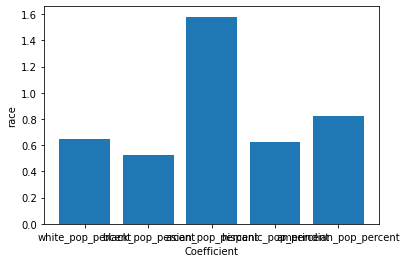

In [ ]:
plt.bar(features[:-1], coefs[:-1])
plt.xlabel('Coefficient')  
plt.ylabel('race')
plt.show() 

# Visual Analysis

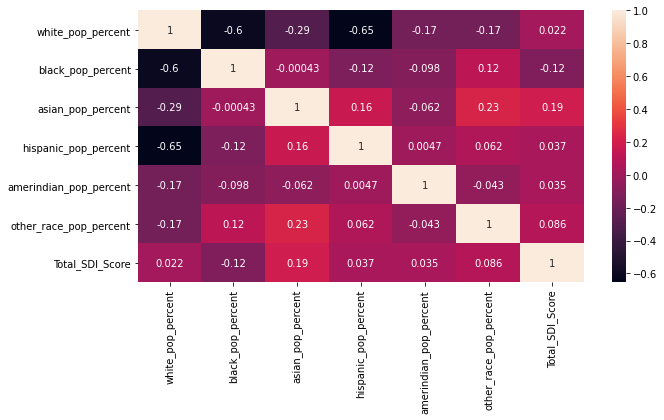

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(regression_df[features + ["Total_SDI_Score"] ].corr(), annot = True)

The intercept for proportion of  white_pop is 0.5400959440382791
The slope for proportion of  white_pop is 0.013538374646164298 

The intercept for proportion of  black_pop is 0.560227922974997
The slope for proportion of  black_pop is -0.10309929781207458 

The intercept for proportion of  asian_pop is 0.5380909826134733
The slope for proportion of  asian_pop is 0.7941572616743567 

The intercept for proportion of  hispanic_pop is 0.547278719396223
The slope for proportion of  hispanic_pop is 0.03138326325797388 



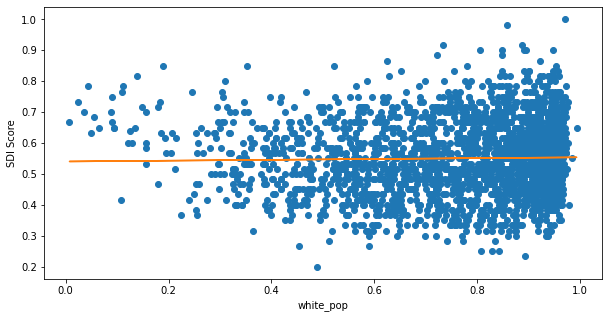

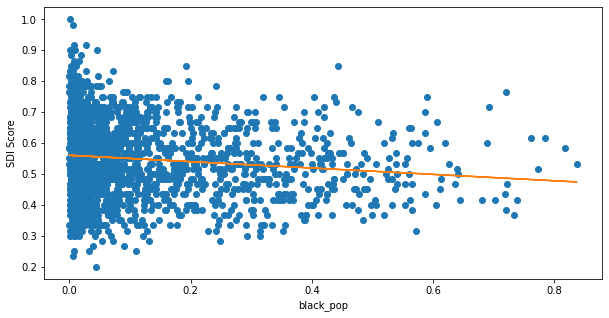

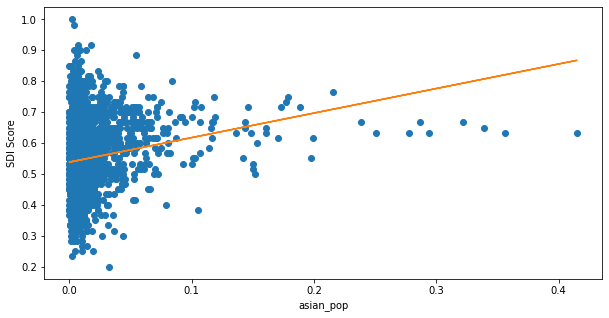

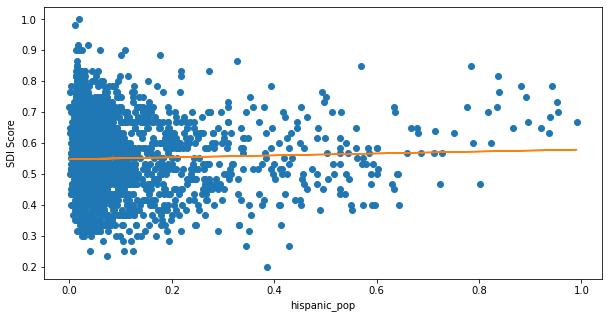

In [ ]:
race_list = [master_df["white_pop"], master_df["black_pop"], master_df["asian_pop"], master_df["hispanic_pop"]]
race_label = ["white_pop", "black_pop", "asian_pop", "hispanic_pop"]
for i in range(len(race_list)):
  X =race_list[i]/master_df["total_pop"]
  y= sdi_df["Total_SDI_Score"]
  plt.figure(figsize=(10,5))
  plt.plot(X,y, 'o')
  plt.ylabel("SDI Score")
  m, b = np.polyfit(X,y, 1)
  plt.plot(X, m*X + b)
  plt.xlabel(race_label[i])
  print(f"The intercept for proportion of ", race_label[i], "is", b)
  print(f"The slope for proportion of ", race_label[i], "is", m, "\n")